# Installing Dependencies

In [65]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
import torch
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns


# Data Loading

In [81]:
# Load the dataset
file_path = 'yelp_review_cleaned_dataset.csv'
df = pd.read_csv(file_path)

# Limit the size of the dataset
df = df.sample(n=5000, random_state=42)

# Add a column for fake reviews with a random distribution
np.random.seed(42)
df['is_fake'] = np.random.choice([0, 1], size=len(df), p=[0.9, 0.1])
# Display basic information about the dataset
df.info(), df.head()

<class 'pandas.core.frame.DataFrame'>
Index: 5000 entries, 6252 to 2764
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   review_id     5000 non-null   object
 1   user_id       5000 non-null   object
 2   business_id   5000 non-null   object
 3   stars         5000 non-null   int64 
 4   useful        5000 non-null   int64 
 5   funny         5000 non-null   int64 
 6   cool          5000 non-null   int64 
 7   text          5000 non-null   object
 8   date          5000 non-null   object
 9   cleaned_text  5000 non-null   object
 10  is_fake       5000 non-null   int64 
dtypes: int64(5), object(6)
memory usage: 468.8+ KB


(None,
                    review_id                 user_id             business_id  \
 6252  DXZtkvp3zgHfwOyQ8He0jQ  gatM0_LzUSqNEmlQcBPiBQ  bXjnfT69E8DJinX-ifOofA   
 4684  BRmDLZSJH_YLsbpJ9_VC6Q  dQIgI_eyox_Q4qK0T6iKmA  jLDwSeoQ_kDQwhnUJQO2yw   
 1731  34ZT45dZD_JXbU5rvuyJgg  0xapSfoASxW3pozvAK_DIQ  4nSnvxK-4lKwZvXDGYK5Uw   
 4742  nHwzviHqA97g7341VT2aWw  _GW_i-3PFWZNMjLc_YMXpw  0hIXH9jMdHov1VrLC8ujUg   
 4521  DAe6ffProBgui30TGuFF4g  tGlcQt6syMPeIGKFUXOlmg  1JtpcHELRrSDoWS80WtzuQ   
 
       stars  useful  funny  cool  \
 6252      1       0      0     0   
 4684      3       1      0     0   
 1731      4       3      0     1   
 4742      5       0      0     0   
 4521      5       2      0     0   
 
                                                    text                 date  \
 6252  I can not believe on how unprofessional we wer...  2018-06-19 20:32:28   
 4684  Before one thing got under my skin, I would sa...  2016-07-05 00:10:57   
 1731  This location has been newly re

# Data Statistics


In [82]:
# Preprocess the cleaned text data
vectorizer = TfidfVectorizer(max_features=300)
text_embeddings = vectorizer.fit_transform(df['cleaned_text']).toarray()

# Encode user_id and business_id
user_encoder = LabelEncoder()
business_encoder = LabelEncoder()
df['user_id_encoded'] = user_encoder.fit_transform(df['user_id'])
df['business_id_encoded'] = business_encoder.fit_transform(df['business_id'])

# Number of reviews, users, and businesses
num_reviews = df.shape[0]
num_users = df['user_id_encoded'].nunique()
num_businesses = df['business_id_encoded'].nunique()

# Create a feature matrix for reviews
review_features = torch.tensor(text_embeddings, dtype=torch.float)

# Create placeholder features for users and businesses
user_features = torch.zeros((num_users, review_features.shape[1]))
business_features = torch.zeros((num_businesses, review_features.shape[1]))

# Concatenate all features to create the final feature matrix
features = torch.cat([review_features, user_features, business_features], dim=0)

# Display the encoded IDs and features
print(df[['user_id_encoded', 'business_id_encoded']].head())
print(features.shape)
print(f'Number of reviews: {num_reviews}')
print(f'Number of users: {num_users}')
print(f'Number of businesses: {num_businesses}')


      user_id_encoded  business_id_encoded
6252             3391                 1583
4684             3144                 1910
1731              168                  251
4742             2808                   73
4521             4377                  102
torch.Size([12470, 300])
Number of reviews: 5000
Number of users: 4894
Number of businesses: 2576


In [83]:
# Correctly calculate the total number of nodes
total_nodes = num_reviews + num_users + num_businesses

# Create edge index (connections between nodes)
user_edges = []
business_edges = []

# Create user edges
for idx, row in df.iterrows():
    user_edge = num_reviews + row['user_id_encoded']
    if user_edge < total_nodes:
        user_edges.append([idx, user_edge])
    else:
        raise ValueError(f"User edge index out of bounds: {user_edge}")

# Create business edges
for idx, row in df.iterrows():
    business_edge = num_reviews + num_users + row['business_id_encoded']
    if business_edge < total_nodes:
        business_edges.append([idx, business_edge])
    else:
        raise ValueError(f"Business edge index out of bounds: {business_edge}")

# Combine edges
edges = torch.tensor(user_edges + business_edges, dtype=torch.long).t().contiguous()

# Ensure the edges do not go out of bounds
if edges.max().item() >= total_nodes:
    raise ValueError(f"Edge index out of bounds: {edges.max().item()} >= {total_nodes}")

# Create PyTorch Geometric data object
data = Data(x=features, edge_index=edges)

print(data)


Data(x=[12470, 300], edge_index=[2, 10000])


# Gnn Model

Epoch 0, Loss: 0.6635631918907166
Epoch 10, Loss: 0.332008421421051
Epoch 20, Loss: 0.33300501108169556
Epoch 30, Loss: 0.3238144814968109
Epoch 40, Loss: 0.316439688205719
Epoch 50, Loss: 0.31560030579566956
Epoch 60, Loss: 0.31379690766334534
Epoch 70, Loss: 0.31235501170158386
Epoch 80, Loss: 0.3113173246383667
Epoch 90, Loss: 0.3103896975517273
Epoch 100, Loss: 0.309526652097702
Epoch 110, Loss: 0.308735728263855
Epoch 120, Loss: 0.30798348784446716
Epoch 130, Loss: 0.3072638511657715
Epoch 140, Loss: 0.3065570294857025
Epoch 150, Loss: 0.3057737350463867
Epoch 160, Loss: 0.30484503507614136
Epoch 170, Loss: 0.30377042293548584
Epoch 180, Loss: 0.30245181918144226
Epoch 190, Loss: 0.3008933663368225
Test Loss: 0.33047035336494446


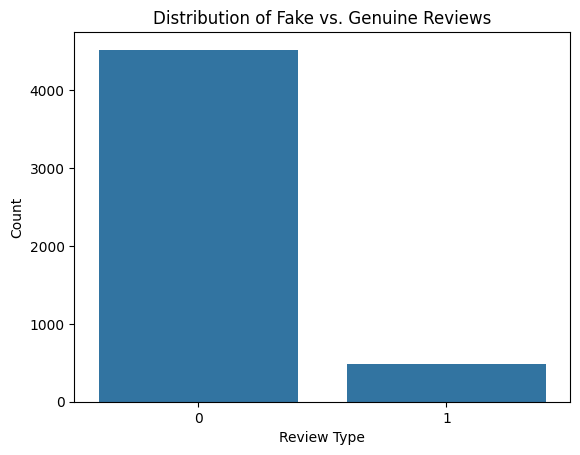

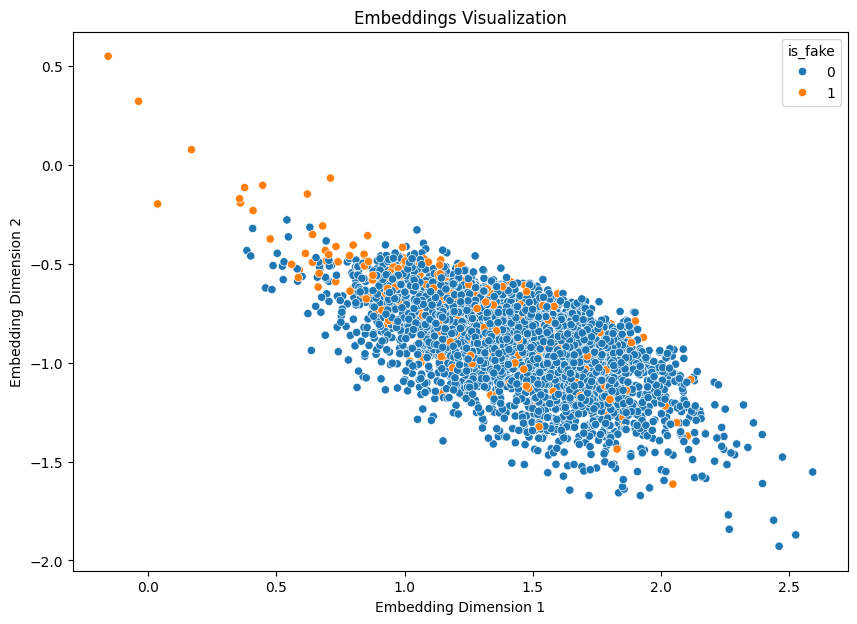

In [95]:
# Handle missing values by imputing the most frequent value
imputer = SimpleImputer(strategy='most_frequent')
df['cleaned_text'] = imputer.fit_transform(df[['cleaned_text']]).ravel()

# Encode user_id and business_id on the entire dataset before splitting
user_encoder = LabelEncoder()
business_encoder = LabelEncoder()

df['user_id_encoded'] = user_encoder.fit_transform(df['user_id'])
df['business_id_encoded'] = business_encoder.fit_transform(df['business_id'])

# Now split the data into training and testing sets
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# Use the already encoded IDs for further processing
train_user_ids = train_df['user_id_encoded'].values  # Use .values here
train_business_ids = train_df['business_id_encoded'].values  # Use .values here
test_user_ids = test_df['user_id_encoded'].values  # Use .values here
test_business_ids = test_df['business_id_encoded'].values  # Use .values here

# Vectorize the text data
#vectorizer = TfidfVectorizer(max_features=300, stop_words='english')
#vectorizer = TfidfVectorizer(max_features=500)
vectorizer = TfidfVectorizer(max_features=100)
train_text_embeddings = vectorizer.fit_transform(train_df['cleaned_text']).toarray()
test_text_embeddings = vectorizer.transform(test_df['cleaned_text']).toarray()

# Create a feature matrix for reviews
train_review_features = torch.tensor(train_text_embeddings, dtype=torch.float)
test_review_features = torch.tensor(test_text_embeddings, dtype=torch.float)

# Number of users and businesses
num_users = df['user_id_encoded'].nunique()
num_businesses = df['business_id_encoded'].nunique()

# Placeholder features for users and businesses (same as training)
user_features = torch.zeros((num_users, train_review_features.shape[1]))
business_features = torch.zeros((num_businesses, train_review_features.shape[1]))

# Concatenate all features to create the final feature matrix for training and testing
train_features = torch.cat([train_review_features, user_features, business_features], dim=0)
test_features = torch.cat([test_review_features, user_features, business_features], dim=0)

# Define the graph data structure
train_edges = torch.tensor([train_user_ids, train_business_ids + num_users], dtype=torch.long)
test_edges = torch.tensor([test_user_ids, test_business_ids + num_users], dtype=torch.long)

# Define graph data for training
train_data = Data(x=train_features, edge_index=train_edges)
test_data = Data(x=test_features, edge_index=test_edges)

#GNN MODEL
class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN, self).__init__()
        torch.manual_seed(42)
        self.conv1 = GCNConv(train_features.shape[1], hidden_channels)
        self.conv2 = GCNConv(hidden_channels, 2)  # Output 2 classes for fake and genuine

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return x

# Initialize the model, loss function, and optimizer
model = GCN(hidden_channels=16)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

# Train the model
model.train()
for epoch in range(200):
    optimizer.zero_grad()
    out = model(train_data)
    loss = criterion(out[:len(train_df)], torch.tensor(train_df['is_fake'].values, dtype=torch.long))
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')

# Model evaluation on test set
model.eval()
with torch.no_grad():
    test_out = model(test_data)
    test_loss = criterion(test_out[:len(test_df)], torch.tensor(test_df['is_fake'].values, dtype=torch.long))
    print(f'Test Loss: {test_loss.item()}')

# Generate embeddings for visualization
with torch.no_grad():
    embeddings = model(train_data).detach().numpy()

# Visualize the distribution of fake vs. genuine reviews
sns.countplot(x='is_fake', data=df)
plt.title('Distribution of Fake vs. Genuine Reviews')
plt.xlabel('Review Type')
plt.ylabel('Count')
plt.show()

# Visualize the embeddings
plt.figure(figsize=(10, 7))
sns.scatterplot(x=embeddings[:len(train_df), 0], y=embeddings[:len(train_df), 1], hue=train_df['is_fake'])
plt.title('Embeddings Visualization')
plt.xlabel('Embedding Dimension 1')
plt.ylabel('Embedding Dimension 2')
plt.show()

# Unsupervised Learning Metrics


In [96]:
# Evaluate using unsupervised learning metrics
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

sil_score = silhouette_score(embeddings[:len(train_df)], train_df['is_fake'])
calinski_harabasz = calinski_harabasz_score(embeddings[:len(train_df)], train_df['is_fake'])
davies_bouldin = davies_bouldin_score(embeddings[:len(train_df)], train_df['is_fake'])

print(f'Silhouette Score: {sil_score}')
print(f'Calinski-Harabasz Index: {calinski_harabasz}')
print(f'Davies-Bouldin Index: {davies_bouldin}')

# Visualize the evaluation metrics
metrics = {
    'Silhouette Score': sil_score,
    'Calinski-Harabasz Index': calinski_harabasz,
    'Davies-Bouldin Index': davies_bouldin,
}

# Count the number of fake reviews identified
num_fake_reviews = df['is_fake'].sum()
print(f'Number of fake reviews: {num_fake_reviews}')

Silhouette Score: 0.08594808727502823
Calinski-Harabasz Index: 103.61690318454035
Davies-Bouldin Index: 3.2181700703745695
Number of fake reviews: 479


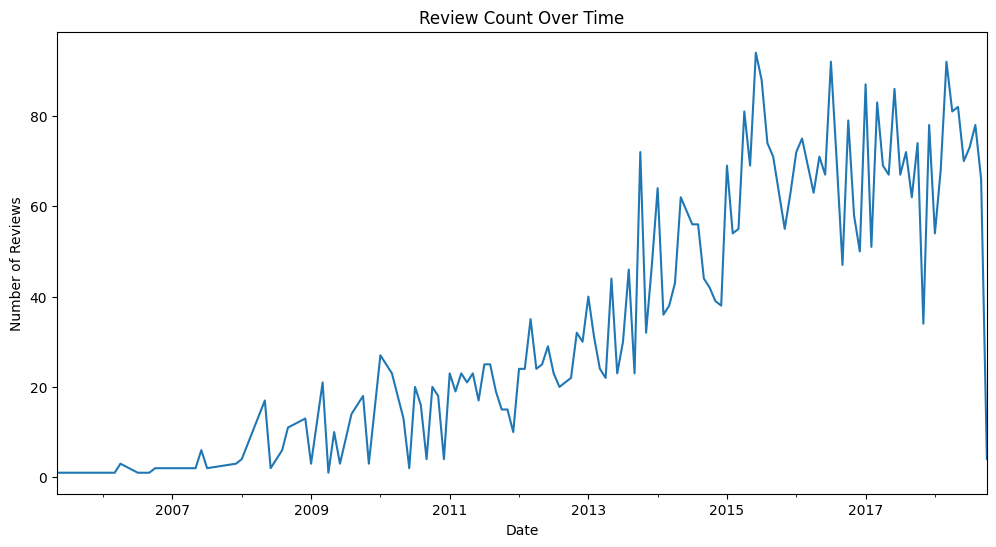

In [87]:
# Ensure the 'date' column is in datetime format
df['date'] = pd.to_datetime(df['date'])

# Group by date to see the trend over time
time_series = df.groupby(df['date'].dt.to_period('M')).size()

# Plot the time series
plt.figure(figsize=(12, 6))
time_series.plot()
plt.title('Review Count Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Reviews')
plt.show()


In [110]:
from sklearn.metrics import average_precision_score
test_probabilities = torch.softmax(test_out[:len(test_df)], dim=1)[:, 1].numpy()
test_labels = test_df['is_fake'].values
ap_score = average_precision_score(test_labels, test_probabilities)
print(f'Average Precision: {ap_score}')
from sklearn.metrics import accuracy_score
# Get the predicted classes from the model's output
_, test_predictions = torch.max(test_out[:len(test_df)], dim=1)
test_predictions = test_predictions.numpy()
test_labels = test_df['is_fake'].values

# Calculate the accuracy
accuracy = accuracy_score(test_labels, test_predictions)
print(f'Accuracy: {accuracy}')



Average Precision: 0.10551305264693994
Accuracy: 0.901


In [115]:
import pandas as pd
import numpy as np
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

# Load GloVe embeddings
embedding_index = {}
with open('glove.6B.300d.txt', 'r', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = coefs

# Create a function to get the average embedding for a document
def get_average_embedding(text, embedding_index, embedding_dim=300):
    words = text.split()
    valid_embeddings = [embedding_index[word] for word in words if word in embedding_index]
    if not valid_embeddings:
        return np.zeros(embedding_dim)
    return np.mean(valid_embeddings, axis=0)

# Load and preprocess the dataset
file_path = 'yelp_review_cleaned_dataset.csv'
df = pd.read_csv(file_path)

# Apply this function to your dataset
df['embedding'] = df['cleaned_text'].apply(lambda x: get_average_embedding(x, embedding_index))

# Convert to a matrix
text_embeddings = np.vstack(df['embedding'].values)
review_features = torch.tensor(text_embeddings, dtype=torch.float)

# Encode user_id and business_id
user_encoder = LabelEncoder()
business_encoder = LabelEncoder()
df['user_id_encoded'] = user_encoder.fit_transform(df['user_id'])
df['business_id_encoded'] = business_encoder.fit_transform(df['business_id'])

# Number of reviews, users, and businesses
num_reviews = df.shape[0]
num_users = df['user_id_encoded'].nunique()
num_businesses = df['business_id_encoded'].nunique()

# Create placeholder features for users and businesses
user_features = torch.zeros((num_users, review_features.shape[1]))
business_features = torch.zeros((num_businesses, review_features.shape[1]))

# Concatenate all features to create the final feature matrix
features = torch.cat([review_features, user_features, business_features], dim=0)

# Create edges for GNN (e.g., user-review, review-business)
edges = []
for i, row in df.iterrows():
    user_id = row['user_id_encoded']
    business_id = row['business_id_encoded']
    review_id = i

    edges.append((user_id, review_id))
    edges.append((review_id, num_reviews + business_id))

# Convert edges to a torch tensor
edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()

# Create the PyG data object
data = Data(x=features, edge_index=edge_index)

# Define the GCN model for unsupervised learning
class GCN(torch.nn.Module):
    def __init__(self, input_dim, hidden_channels, output_dim):
        super(GCN, self).__init__()
        torch.manual_seed(42)
        self.conv1 = GCNConv(input_dim, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, input_dim)  # Ensure the output dimension matches the input dimension

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return x

# Initialize the model, optimizer
model = GCN(input_dim=features.shape[1], hidden_channels=64, output_dim=features.shape[1])  # Match output_dim to input_dim
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Unsupervised training loop
model.train()
for epoch in range(200):
    optimizer.zero_grad()
    out = model(data)
    loss = F.mse_loss(out, data.x)  # MSE loss with matched dimensions
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')

# Extract embeddings for clustering
model.eval()
with torch.no_grad():
    embeddings = model(data).numpy()

# Apply k-means clustering
kmeans = KMeans(n_clusters=2, random_state=42)
clusters = kmeans.fit_predict(embeddings[:len(df)])

# Calculate unsupervised metrics
silhouette = silhouette_score(embeddings[:len(df)], clusters)
calinski_harabasz = calinski_harabasz_score(embeddings[:len(df)], clusters)
davies_bouldin = davies_bouldin_score(embeddings[:len(df)], clusters)

print(f'Silhouette Score: {silhouette}')
print(f'Calinski-Harabasz Index: {calinski_harabasz}')
print(f'Davies-Bouldin Index: {davies_bouldin}')


Epoch 0, Loss: 0.02127368375658989
Epoch 10, Loss: 0.00851045548915863
Epoch 20, Loss: 0.006443510297685862
Epoch 30, Loss: 0.006084221415221691
Epoch 40, Loss: 0.005849828477948904
Epoch 50, Loss: 0.00570199079811573
Epoch 60, Loss: 0.00560543779283762
Epoch 70, Loss: 0.005522862076759338
Epoch 80, Loss: 0.005435003433376551
Epoch 90, Loss: 0.005269757471978664
Epoch 100, Loss: 0.005084102042019367
Epoch 110, Loss: 0.0049384720623493195
Epoch 120, Loss: 0.004826072603464127
Epoch 130, Loss: 0.004727123770862818
Epoch 140, Loss: 0.004663120023906231
Epoch 150, Loss: 0.004582175053656101
Epoch 160, Loss: 0.004403746221214533
Epoch 170, Loss: 0.004306087736040354
Epoch 180, Loss: 0.004315246362239122
Epoch 190, Loss: 0.004221853334456682
Silhouette Score: 0.365933358669281
Calinski-Harabasz Index: 7555.611365954148
Davies-Bouldin Index: 1.0062234018134986
